## JMPY  
Jmpy is an analysis library created to simplify common plotting and modeling tasks.  Simplicity, a common plotting signature, and ease of use are preferred over flexibility.

The goal is to create mini-reports with each function for better visualization of data.
___
Currently, there are two modules:  plotting and modeling.  
Plotting is used to make pretty graphs, and modeling is used to anaylyze data with visual output.  

This module relies heavily on statsmodels, patsy, and pandas.

In [1]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jmpy.plotting as jp
import jmpy.modeling as jm

import warnings
warnings.filterwarnings('ignore')

### Plotting  
___
Create some artifical data for our analysis:

In [2]:
nsamples = 250
xc = np.linspace(0, 100, nsamples)
xc2 = xc**2
xd = np.random.choice([1, 3, 5, 7], nsamples)
xe = np.random.choice([10, 30, 50], nsamples)
xf = np.random.choice([.1, .4], nsamples)
xz = np.random.choice([np.nan], nsamples)
xg = np.random.normal(size=nsamples)*15

X = np.column_stack((xc, xc2, xd, xe))
beta = np.array([1, .01, 17, .001])

e = np.random.normal(size=nsamples)*10
ytrue = np.dot(X, beta)
y = ytrue + e

data = {}
data['xc'] = xc
data['xc2'] = xc2
data['xd'] = xd
data['xe'] = xe
data['xf'] = xf
data['xg'] = xg
data['y'] = y
data['ytrue'] = ytrue

df = pd.DataFrame.from_dict(data)
df.head()

,xc,xc2,xd,xe,xf,xg,y,ytrue
0,0.000000,0.000000,7,50,0.4,7.628784,114.007255,119.050000
1,0.401606,0.161288,3,10,0.4,16.637129,52.239746,51.413219
2,0.803213,0.645151,5,50,0.1,-14.003879,59.695922,85.859664
3,1.204819,1.451589,3,50,0.4,-2.778978,42.663512,52.269335
4,1.606426,2.580604,5,10,0.4,17.615734,95.051037,86.642232


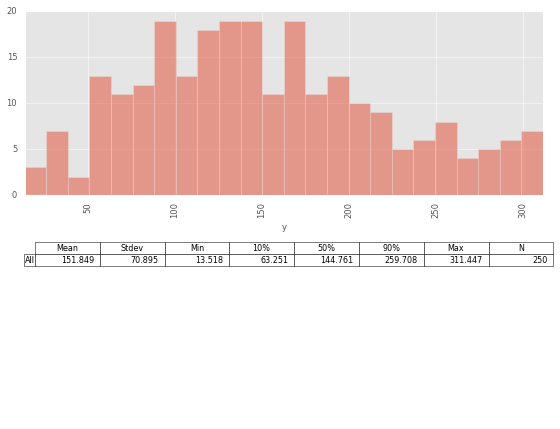

In [3]:
jp.histogram('y', df)

Lets start to visualize how our artifical data looks.  First, plot a histogram of the results.

If you want to look at the data color coded by a categorical variable, you need to specify "legend":

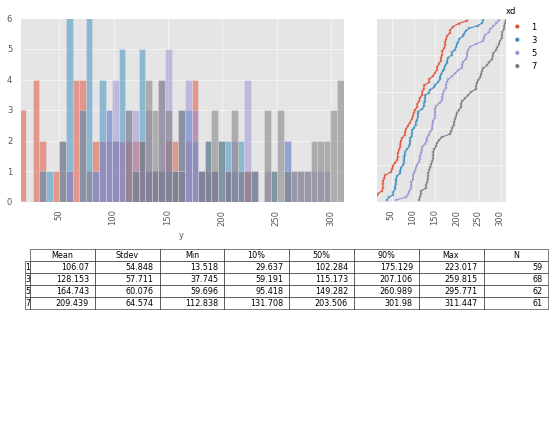

In [4]:
jp.histogram('y', df, legend='xd', bins=50, cumprob=True)

You can also look at variablility and cumprob plots:

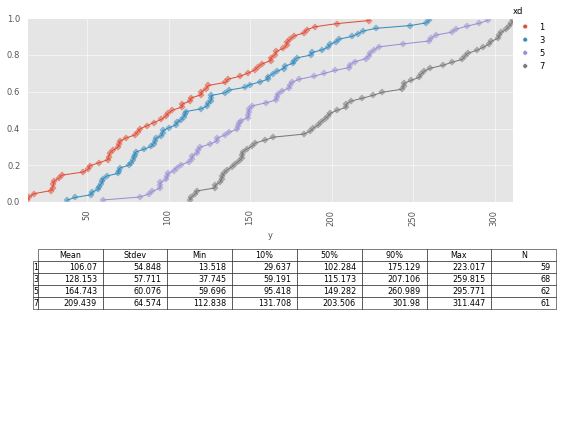

In [5]:
jp.cumprob('y', df, legend='xd', marker='D')

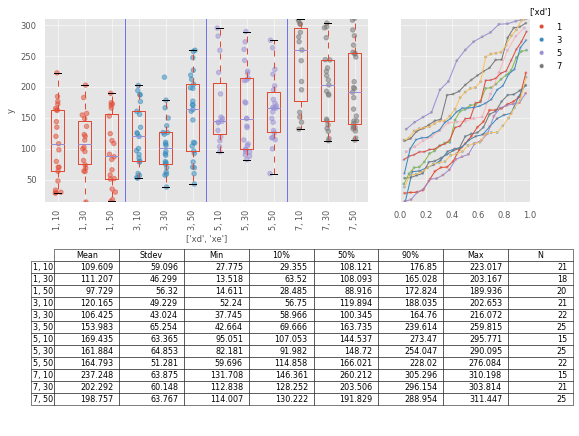

In [6]:
jp.varchart(['xd', 'xe'], 'y', data=df, legend=['xd'], cumprob=True, figsize=(9,6))

___
Lets look at the data with a boxplot to see if there is any difference between the groups defined by xd:

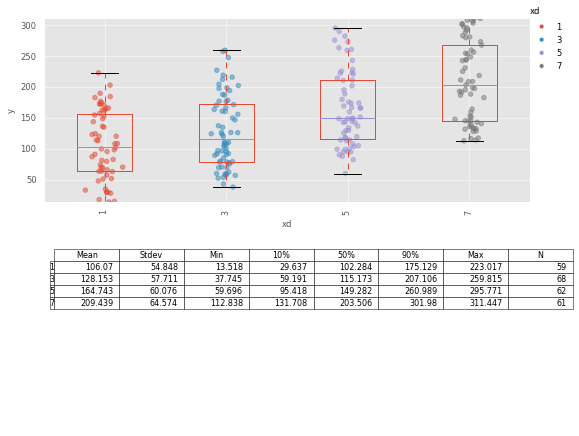

In [7]:
jp.boxplot(x='xd', y='y', data=df, legend='xd', cumprob=False)

___
You can also create a scatter plot with a fit.

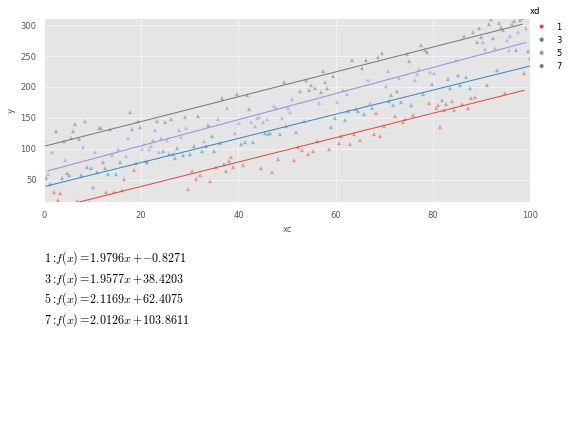

In [8]:
jp.scatter(x='xc', y='y', data=df, legend='xd', fit='linear', marker='^')

We can generate the same graph using the arrays directly without creating the pandas dataframe.  You can fit the data by specifying a fit param.  Currently, linear, quadratic, smooth, and interpolate are supported.

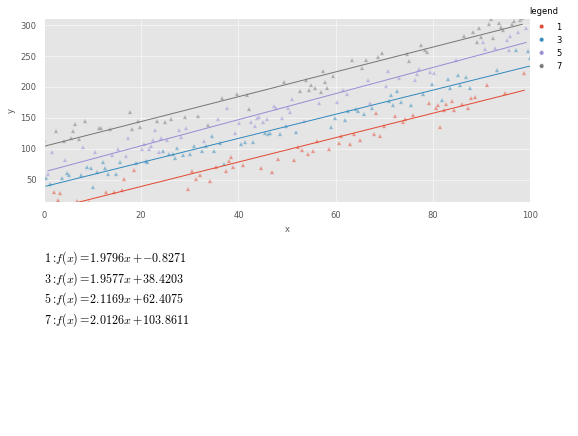

In [9]:
jp.scatter(xc, y=y, legend=xd, fit='linear', marker='^')

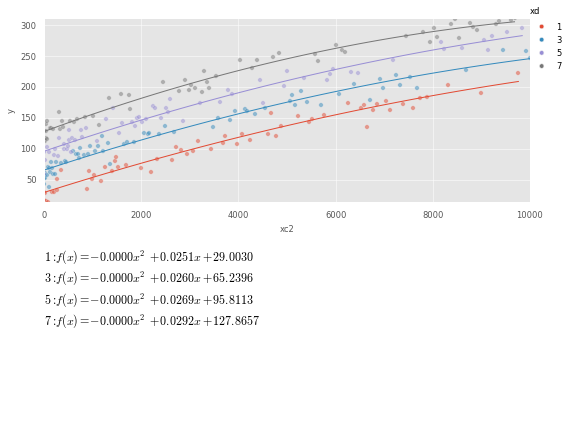

In [10]:
jp.scatter('xc2', 'y', df, legend='xd', fit='quadratic', marker='o')

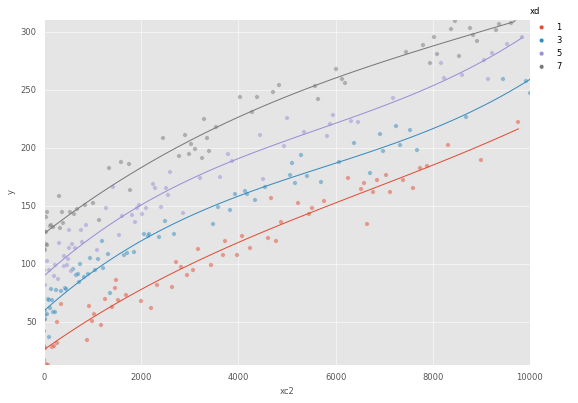

In [11]:
# fitparams get passed into the fitting functions.  Smoothing uses the scipy Univariate spline function.
jp.scatter(x='xc2', y='y', data=df, legend='xd', fit='smooth', fitparams={'s': 1e6})

Contour plots can also be created as well:

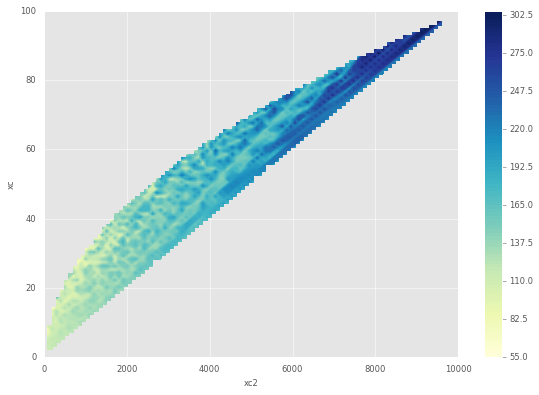

In [12]:
jp.contour('xc2', 'xc', 'y', df, cmap='YlGnBu')

___
### Modeling  
#### Ordinary Least Squares
Now that we have visualized some of the data, lets do some modeling.  jmpy current supports two types of linear modeling:  ordinary least squares and robust linear model, all built on the statsmodels functions.  Lets do the OLS first.  

All models are specified based on the patsy text formulas that are very similar to R.  

By default, only 80% of the data is used to fit the model, and the other 20% is plotted alongside the data to validate the model results.  This can be changed by specifying a different sample_rate parameter.

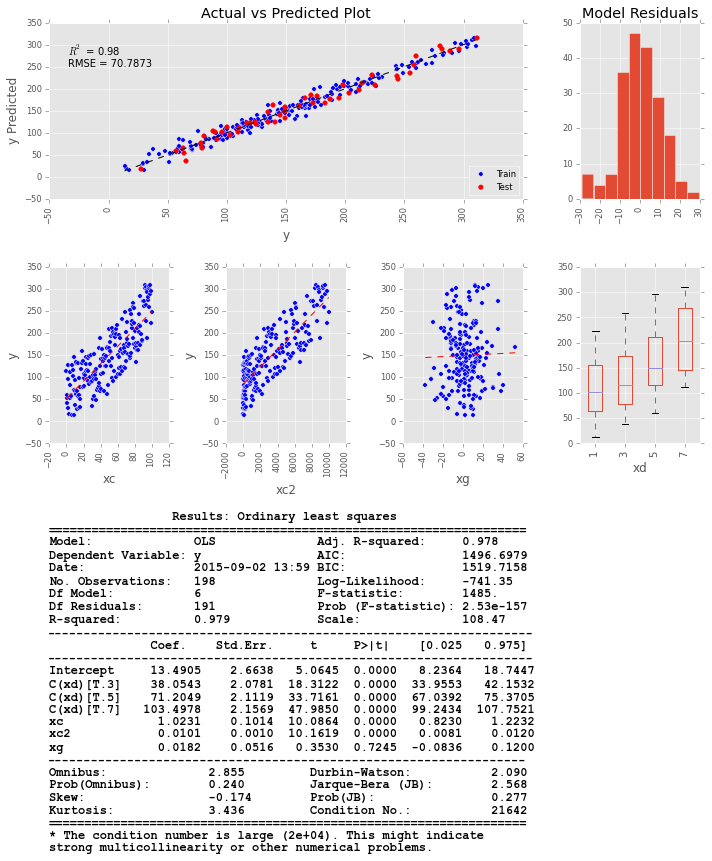

In [13]:
model = 'y ~ xc + xc2 + C(xd) +  xg'
jm.fit(model, data=df, sample_rate=.8, model_type='ols');

___
#### Robust Linear Model
Now... what if we had a couple of outliers in our dataset... lets create some outliers

In [17]:
dfo = df.copy()
p = np.random.uniform(0, 1, size=dfo.y.shape)
err = np.random.normal(size=dfo.y.shape)

df['yout'] = dfo.y + np.greater_equal(p, 0.9) * (dfo.y * err)

Our coefficient estimates will be skewed due to the outliers.

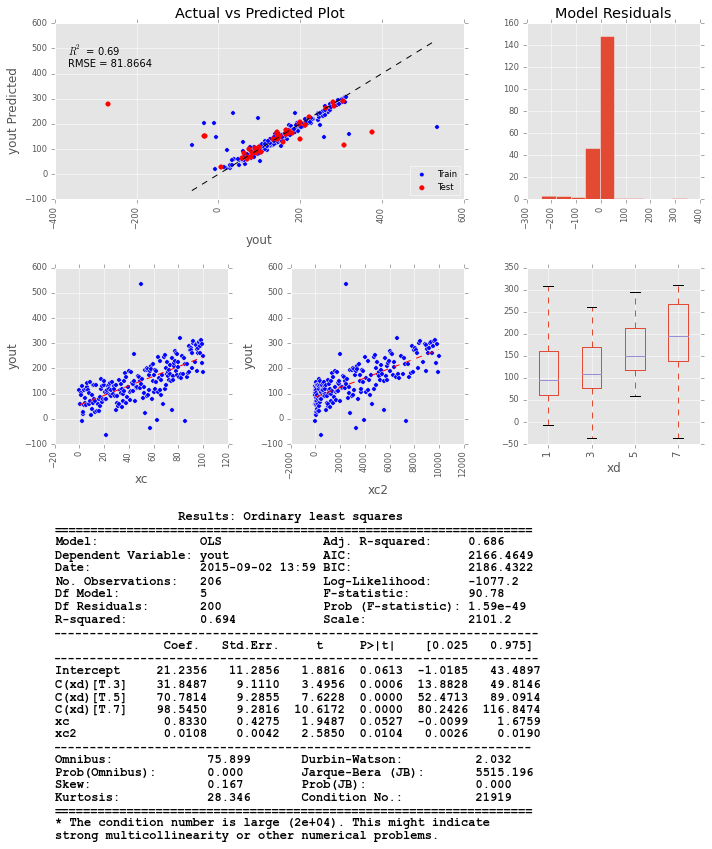

In [18]:
model = 'yout ~ xc + xc2 + C(xd)'
jm.fit(model, data=dfo, sample_rate=.8, model_type='ols');

Employing the robust linear model, we can minimize the influence of the outliers, and get better coefficient predictions.

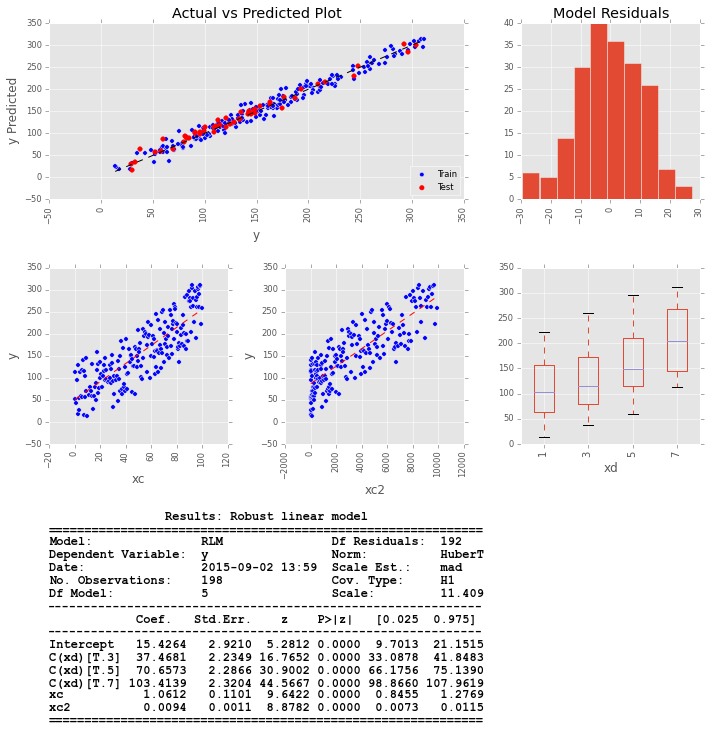

In [19]:
model = 'y ~ xc + xc2 + C(xd)'
jm.fit(model, data=dfo, sample_rate=.8, model_type='rlm');

Our parameter estimates using the robust linear model are much closer to the truth, than using the OLS.

#### Overfitting  
Next we will test how robust the parameter estimates are by running many iterations of the model, and randomly subsetting the data, and then looking at the parameter estimate distributions.

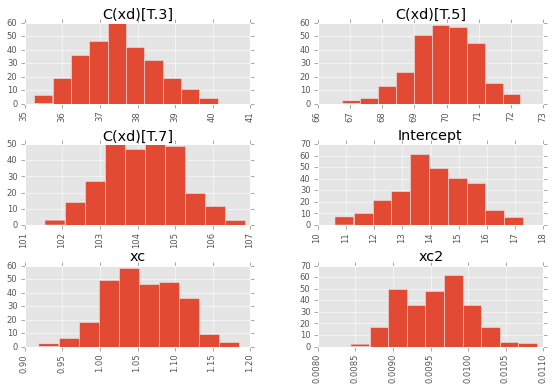

In [20]:
model = 'y ~ xc + xc2 + C(xd)'
jm.check_estimates(model, data=df, sample_rate=.8, model_type='ols', iterations=275);